Running the model for SNR: -10 dB
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_true sample (first 10): [0 1 0 0 0 0 0 0 0 0]
y_pred_binary sample (first 10): [0 1 0 0 0 0 0 0 0 0]
Bit errors: 670
Total bits: 10000
Binary Task BER: 0.06700
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
y_true sample (first 10): [[1 1 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 0 1]]
y_pred_binary sample (first 10): [[1 1 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 1]
 [0 0 0 0]
 [0 1 1 0]
 [1 1 0 0]]
Bit errors: 12653
Total bits: 40000
Categorical Task BER: 0.31633
SNR: -10 dB - Binary Task BER: 0.067
SNR: -10 dB - Categorical Task BER: 0.316325
Running the model for SNR: -5 dB
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
y_true sample (first 10): [0 1 0 0 0 0 0 0 0 0]
y_pred_binary sample (first 10): [0 1 0 0 0 0 0 0 0 0]
Bit errors: 367
Total bits: 10000
Binary Task BER: 0.03670
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_true sample 

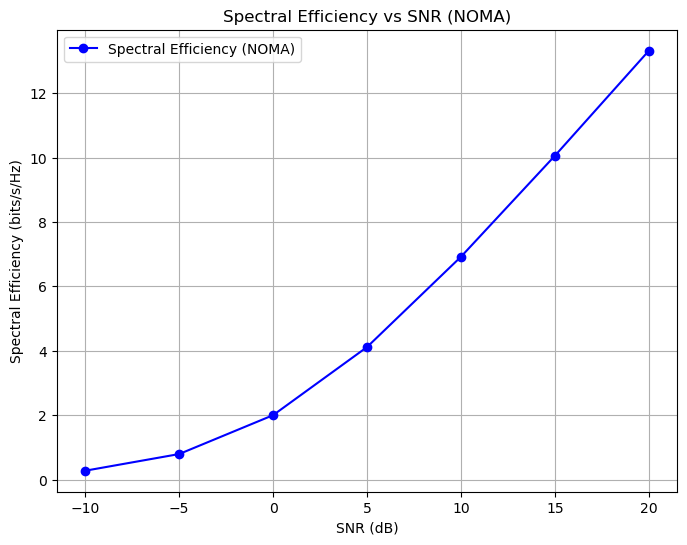

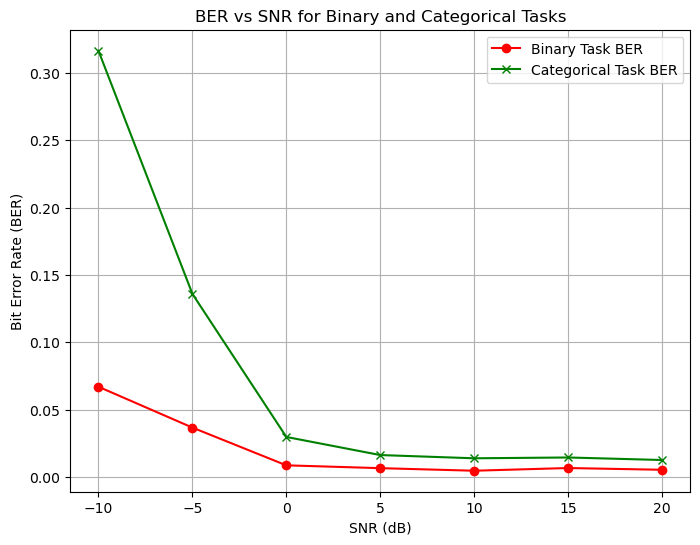

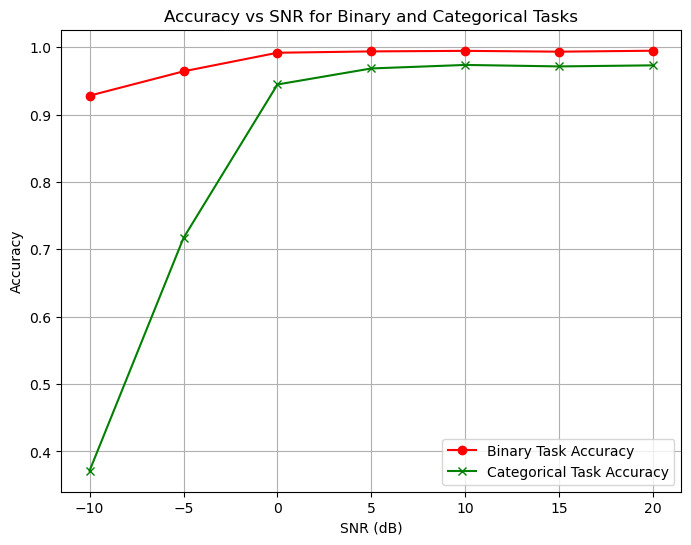

In [1]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import math

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the data and normalize
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255.0
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255.0

# Define the AWGN function
def add_awgn_noise(signal, snr_db):
    """Add AWGN noise to the signal with a given SNR in dB."""
    snr = 10 ** (snr_db / 10.0)
    signal_power = tf.reduce_mean(tf.square(signal))
    noise_power = signal_power / snr
    noise = tf.random.normal(shape=tf.shape(signal), mean=0.0, stddev=tf.sqrt(noise_power))
    return signal + noise

# Binary classification labels for Task 1 (digit "2")
y_train_binary = (y_train == 2).astype('float32')
y_test_binary = (y_test == 2).astype('float32')

# Categorical classification labels for Task 2
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

# Create sample weights for the binary classification task
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_binary), y=y_train_binary)
sample_weights_binary = np.where(y_train_binary == 1, class_weights[1], class_weights[0])

# Define the CU Encoder
class CUEncoder(tf.keras.Model):
    def __init__(self):
        super(CUEncoder, self).__init__()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(64, activation='tanh')
    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.fc(x)
        return x

# SU1 Encoder for Task 1
class SU1(tf.keras.Model):
    def __init__(self):
        super(SU1, self).__init__()
        self.encoder = layers.Dense(16, activation='tanh')
    
    def call(self, inputs):
        x = self.encoder(inputs)
        return x

# SU2 Encoder for Task 2
class SU2(tf.keras.Model):
    def __init__(self):
        super(SU2, self).__init__()
        self.encoder = layers.Dense(16, activation='tanh')
    
    def call(self, inputs):
        x = self.encoder(inputs)
        return x

# Digital Modulation (BPSK)
def bpsk_modulate(signal):
    return 2 * signal - 1  # Maps 0 to -1 and 1 to +1

# Superimpose signals using NOMA with different power levels
def noma_superimpose(x1, x2, power1=0.3, power2=0.7):
    """Superimpose two signals using different power levels as per NOMA."""
    return tf.sqrt(power1) * x1 + tf.sqrt(power2) * x2

# Define the DNN-based base station for signal separation
class BaseStation(tf.keras.Model):
    def __init__(self):
        super(BaseStation, self).__init__()
        self.dnn = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu')
        ])
        self.su1_decoder = layers.Dense(1, activation='sigmoid', name='binary_output')
        self.su2_decoder = layers.Dense(10, activation='softmax', name='categorical_output')
    
    def call(self, inputs):
        x = self.dnn(inputs)
        su1_output = self.su1_decoder(x)  # Binary classification output
        su2_output = self.su2_decoder(x)  # Categorical classification output
        return {'binary_output': su1_output, 'categorical_output': su2_output}

# Define the overall Multi-Task NOMA-based communication model
class MultiTaskNOMA(tf.keras.Model):
    def __init__(self, snr_db):
        super(MultiTaskNOMA, self).__init__()
        self.cu_encoder = CUEncoder()
        self.su1 = SU1()
        self.su2 = SU2()
        self.base_station = BaseStation()
        self.snr_db = snr_db
    
    def call(self, inputs):
        # CU Encoder
        cu_output = self.cu_encoder(inputs)
        
        # Process through SU1 and SU2 Encoders
        su1_output = self.su1(cu_output)
        su2_output = self.su2(cu_output)
        
        # BPSK Modulation
        su1_modulated = bpsk_modulate(su1_output)
        su2_modulated = bpsk_modulate(su2_output)
        
        # NOMA Superimpose
        superimposed_signal = noma_superimpose(su1_modulated, su2_modulated)
        
        # Pass through AWGN channel
        noisy_signal = add_awgn_noise(superimposed_signal, self.snr_db)
        
        # Base Station separates and decodes the signals
        return self.base_station(noisy_signal)

# Calculate BER
def calculate_ber(y_true, y_pred, task_type='binary'):
    """Calculate Bit Error Rate (BER) and print debugging info."""
    y_pred_binary = np.round(y_pred).astype(int)
    y_true = y_true.astype(int)
    
    if task_type == 'binary':
        # For binary task, ensure y_true and y_pred are 1D
        y_pred_binary = np.squeeze(y_pred_binary)
        
        # Print the first 10 samples of y_true and y_pred
        print(f'y_true sample (first 10): {y_true[:10]}')
        print(f'y_pred_binary sample (first 10): {y_pred_binary[:10]}')

    elif task_type == 'categorical':
        # For categorical task, y_true and y_pred are bit-packed
        print(f'y_true sample (first 10): {y_true[:10]}')
        print(f'y_pred_binary sample (first 10): {y_pred_binary[:10]}')
    
    # Calculate bit errors
    bit_errors = np.sum(y_true != y_pred_binary)
    total_bits = y_true.size
    ber = bit_errors / total_bits

    # Print the bit error information
    print(f'Bit errors: {bit_errors}')
    print(f'Total bits: {total_bits}')
    print(f'{task_type.capitalize()} Task BER: {ber:.5f}')

    return ber

# Calculate Spectral Efficiency
def calculate_spectral_efficiency(snr_db):
    """Calculate the spectral efficiency for NOMA based on SNR."""
    snr_linear = 10 ** (snr_db / 10.0)
    se_user1 = math.log2(1 + snr_linear)
    se_user2 = math.log2(1 + snr_linear)
    return se_user1 + se_user2

# List of SNR values
snr_values = [-10, -5, 0, 5, 10, 15, 20]
spectral_efficiencies = []
binary_accuracies = []
categorical_accuracies = []
binary_bers = []
categorical_bers = []

# Iterate over different SNR values
for snr_db in snr_values:
    print(f"Running the model for SNR: {snr_db} dB")
    
    # Instantiate the model with the current SNR
    model = MultiTaskNOMA(snr_db)
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss={'binary_output': 'binary_crossentropy', 'categorical_output': 'categorical_crossentropy'},
                  metrics={'binary_output': 'accuracy', 'categorical_output': 'accuracy'})

    # Train the model for the current SNR value
    history = model.fit(x_train, {'binary_output': y_train_binary, 'categorical_output': y_train_categorical},
                        sample_weight={'binary_output': sample_weights_binary, 'categorical_output': np.ones_like(y_train_binary)},
                        epochs=50,
                        batch_size=128,
                        validation_data=(x_test, {'binary_output': y_test_binary, 'categorical_output': y_test_categorical}),
                        verbose=0)

    # Calculate Spectral Efficiency for the current SNR and append
    total_se_noma = calculate_spectral_efficiency(snr_db)
    spectral_efficiencies.append(total_se_noma)  # Ensure this line is executed inside the loop

    # Evaluate accuracy for both tasks
    evaluation_results = model.evaluate(x_test, {'binary_output': y_test_binary, 'categorical_output': y_test_categorical}, verbose=0)
    binary_accuracies.append(evaluation_results[1])  # Binary classification accuracy
    categorical_accuracies.append(evaluation_results[2])  # Categorical classification accuracy

    # Calculate BER for binary task and print detailed results
    y_pred_binary = model.predict(x_test)['binary_output']
    binary_ber = calculate_ber(y_test_binary, y_pred_binary, task_type='binary')
    binary_bers.append(binary_ber)

    # Calculate BER for categorical task and print detailed results
    y_pred_categorical = model.predict(x_test)['categorical_output']
    y_pred_categorical_bin = np.unpackbits(np.array(np.argmax(y_pred_categorical, axis=1), dtype=np.uint8).reshape(-1, 1), axis=1, bitorder='little')[:,:4]
    y_true_categorical_bin = np.unpackbits(np.array(np.argmax(y_test_categorical, axis=1), dtype=np.uint8).reshape(-1, 1), axis=1, bitorder='little')[:,:4]
    categorical_ber = calculate_ber(y_true_categorical_bin, y_pred_categorical_bin, task_type='categorical')
    categorical_bers.append(categorical_ber)

    print(f"SNR: {snr_db} dB - Binary Task BER: {binary_ber}")
    print(f"SNR: {snr_db} dB - Categorical Task BER: {categorical_ber}")

# Now, plot the results
# Plot Spectral Efficiency vs SNR
if len(spectral_efficiencies) == len(snr_values):
    plt.figure(figsize=(8, 6))
    plt.plot(snr_values, spectral_efficiencies, marker='o', color='b', label='Spectral Efficiency (NOMA)')
    plt.title('Spectral Efficiency vs SNR (NOMA)')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Spectral Efficiency (bits/s/Hz)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print(f"Spectral efficiencies length mismatch: {len(spectral_efficiencies)} != {len(snr_values)}")

# Plot BER vs SNR
if len(binary_bers) == len(snr_values) and len(categorical_bers) == len(snr_values):
    plt.figure(figsize=(8, 6))
    plt.plot(snr_values, binary_bers, marker='o', color='r', label='Binary Task BER')
    plt.plot(snr_values, categorical_bers, marker='x', color='g', label='Categorical Task BER')
    plt.title('BER vs SNR for Binary and Categorical Tasks')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print(f"BER length mismatch: {len(binary_bers)}, {len(categorical_bers)} != {len(snr_values)}")

# Plot Accuracy vs SNR
if len(binary_accuracies) == len(snr_values) and len(categorical_accuracies) == len(snr_values):
    plt.figure(figsize=(8, 6))
    plt.plot(snr_values, binary_accuracies, marker='o', color='r', label='Binary Task Accuracy')
    plt.plot(snr_values, categorical_accuracies, marker='x', color='g', label='Categorical Task Accuracy')
    plt.title('Accuracy vs SNR for Binary and Categorical Tasks')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print(f"Accuracy length mismatch: {len(binary_accuracies)}, {len(categorical_accuracies)} != {len(snr_values)}")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import math

# Load MNIST dataset
(x_train_F, y_train_F), (x_test_F, y_test_F) = mnist.load_data()

# Flatten the data and normalize
x_train_F = x_train_F.reshape((60000, 28*28)).astype('float32') / 255.0
x_test_F = x_test_F.reshape((10000, 28*28)).astype('float32') / 255.0

# Define the AWGN function
def add_awgn_noise_F(signal_F, snr_db_F):
    """Add AWGN noise to the signal with a given SNR in dB."""
    snr_F = 10 ** (snr_db_F / 10.0)
    signal_power_F = tf.reduce_mean(tf.square(signal_F))
    noise_power_F = signal_power_F / snr_F
    noise_F = tf.random.normal(shape=tf.shape(signal_F), mean=0.0, stddev=tf.sqrt(noise_power_F))
    return signal_F + noise_F

# Binary classification labels for Task 1 (digit "2")
y_train_binary_F = (y_train_F == 2).astype('float32')
y_test_binary_F = (y_test_F == 2).astype('float32')

# Categorical classification labels for Task 2
y_train_categorical_F = to_categorical(y_train_F, 10)
y_test_categorical_F = to_categorical(y_test_F, 10)

# Create sample weights for the binary classification task
class_weights_F = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_binary_F), y=y_train_binary_F)
sample_weights_binary_F = np.where(y_train_binary_F == 1, class_weights_F[1], class_weights_F[0])

# Create a default sample weights array for the categorical output
sample_weights_categorical_F = np.ones_like(y_train_binary_F)

# BPSK Modulation
def bpsk_modulate_F(signal_F):
    """Apply BPSK modulation to a signal."""
    return 2 * signal_F - 1  # Maps 0 to -1 and 1 to +1

# Define the CU Encoder
class CUEncoder_F(tf.keras.Model):
    def __init__(self):
        super(CUEncoder_F, self).__init__()
        self.flatten_F = layers.Flatten()
        self.fc_F = layers.Dense(64, activation='tanh')
    
    def call(self, inputs_F):
        x_F = self.flatten_F(inputs_F)
        x_F = self.fc_F(x_F)
        return x_F

# SU1 Encoder for Task 1
class SU1Encoder_F(tf.keras.Model):
    def __init__(self):
        super(SU1Encoder_F, self).__init__()
        self.encoder_F = layers.Dense(16, activation='tanh')
    
    def call(self, inputs_F):
        x_F = self.encoder_F(inputs_F)
        return x_F

# SU2 Encoder for Task 2
class SU2Encoder_F(tf.keras.Model):
    def __init__(self):
        super(SU2Encoder_F, self).__init__()
        self.encoder_F = layers.Dense(16, activation='tanh')
    
    def call(self, inputs_F):
        x_F = self.encoder_F(inputs_F)
        return x_F

# SU1 Decoder for Task 1
class SU1Decoder_F(tf.keras.Model):
    def __init__(self):
        super(SU1Decoder_F, self).__init__()
        self.decoder_F = layers.Dense(1, activation='sigmoid', name='binary_output')  # Binary output for Task 1
    
    def call(self, inputs_F):
        x_F = self.decoder_F(inputs_F)
        return x_F

# SU2 Decoder for Task 2
class SU2Decoder_F(tf.keras.Model):
    def __init__(self):
        super(SU2Decoder_F, self).__init__()
        self.decoder_F = layers.Dense(10, activation='softmax', name='categorical_output')  # Categorical output for Task 2
    
    def call(self, inputs_F):
        x_F = self.decoder_F(inputs_F)
        return x_F

# Define the MultiTaskNetwork model
class MultiTaskNetwork_F(tf.keras.Model):
    def __init__(self, snr_db_F):
        super(MultiTaskNetwork_F, self).__init__()
        self.cu_encoder_F = CUEncoder_F()    # Common CU Encoder
        self.su1_encoder_F = SU1Encoder_F()  # SU1 Encoder for Task 1
        self.su2_encoder_F = SU2Encoder_F()  # SU2 Encoder for Task 2
        self.su1_decoder_F = SU1Decoder_F()  # SU1 Decoder for Task 1
        self.su2_decoder_F = SU2Decoder_F()  # SU2 Decoder for Task 2
        self.snr_db_F = snr_db_F  # Add SNR as a parameter
    
    def call(self, inputs_F):
        # Step 1: Encode input through CU Encoder
        cu_output_F = self.cu_encoder_F(inputs_F)
        
        # Step 2: SU1 Encoder and SU2 Encoder
        su1_encoded_F = self.su1_encoder_F(cu_output_F)  # Task 1 encoding
        su2_encoded_F = self.su2_encoder_F(cu_output_F)  # Task 2 encoding
        
        # Step 3: BPSK Modulation
        su1_modulated_F = bpsk_modulate_F(su1_encoded_F)  # Task 1 modulation
        su2_modulated_F = bpsk_modulate_F(su2_encoded_F)  # Task 2 modulation
        
        # Step 4: AWGN Channel
        su1_noisy_F = add_awgn_noise_F(su1_modulated_F, self.snr_db_F)  # Task 1 noisy signal
        su2_noisy_F = add_awgn_noise_F(su2_modulated_F, self.snr_db_F)  # Task 2 noisy signal
        
        # Step 5: SU1 Decoder and SU2 Decoder
        su1_output_F = self.su1_decoder_F(su1_noisy_F)  # Task 1 output (binary classification)
        su2_output_F = self.su2_decoder_F(su2_noisy_F)  # Task 2 output (categorical classification)
        
        return {'binary_output': su1_output_F, 'categorical_output': su2_output_F}

# Calculate BER
def calculate_ber_F(y_true_F, y_pred_F, task_type_F='binary'):
    """Calculate Bit Error Rate (BER) and print debugging info."""
    y_pred_binary_F = np.round(y_pred_F).astype(int)
    y_true_F = y_true_F.astype(int)
    
    if task_type_F == 'binary':
        # For binary task, ensure y_true and y_pred are 1D
        y_pred_binary_F = np.squeeze(y_pred_binary_F)
        
        # Print the first 10 samples of y_true and y_pred
        print(f'y_true sample (first 10): {y_true_F[:10]}')
        print(f'y_pred_binary sample (first 10): {y_pred_binary_F[:10]}')

    elif task_type_F == 'categorical':
        # For categorical task, y_true and y_pred are bit-packed
        print(f'y_true sample (first 10): {y_true_F[:10]}')
        print(f'y_pred_binary sample (first 10): {y_pred_binary_F[:10]}')
    
    # Calculate bit errors
    bit_errors_F = np.sum(y_true_F != y_pred_binary_F)
    total_bits_F = y_true_F.size
    ber_F = bit_errors_F / total_bits_F

    # Print the bit error information
    print(f'Bit errors: {bit_errors_F}')
    print(f'Total bits: {total_bits_F}')
    print(f'{task_type_F.capitalize()} Task BER: {ber_F:.5f}')

    return ber_F

# Calculate Spectral Efficiency for FDMA
def calculate_spectral_efficiency_fdma_F(snr_db_F):
    """Calculate the spectral efficiency for FDMA based on SNR."""
    snr_linear_F = 10 ** (snr_db_F / 10.0)
    
    # Spectral Efficiency for both users (since they use separate frequency bands)
    se_user1_F = math.log2(1 + snr_linear_F)
    se_user2_F = math.log2(1 + snr_linear_F)
    
    # Since FDMA allocates separate bandwidth, the total SE is averaged across users
    total_se_fdma_F = (se_user1_F + se_user2_F) / 2
    return total_se_fdma_F

# Instantiate and train the model for different SNR values
snr_values_F = [-10, -5, 0, 5, 10, 15, 20]
spectral_efficiencies_F = []
binary_accuracies_F = []
categorical_accuracies_F = []
binary_bers_F = []
categorical_bers_F = []

for snr_db_F in snr_values_F:
    print(f"Running the model for SNR: {snr_db_F} dB")
    
    # Instantiate the model with the current SNR
    model_F = MultiTaskNetwork_F(snr_db_F)
    
    # Compile the model
    model_F.compile(optimizer='adam',
                    loss={'binary_output': 'binary_crossentropy', 'categorical_output': 'categorical_crossentropy'},
                    metrics={'binary_output': 'accuracy', 'categorical_output': 'accuracy'})

    # Train the model for the current SNR value
    history_F = model_F.fit(x_train_F, {'binary_output': y_train_binary_F, 'categorical_output': y_train_categorical_F},
                            sample_weight={'binary_output': sample_weights_binary_F, 'categorical_output': sample_weights_categorical_F},
                            epochs=50,
                            batch_size=128,
                            validation_data=(x_test_F, {'binary_output': y_test_binary_F, 'categorical_output': y_test_categorical_F}),
                            verbose=0)

    # Evaluate the model on both tasks
    evaluation_results_F = model_F.evaluate(x_test_F, {'binary_output': y_test_binary_F, 'categorical_output': y_test_categorical_F}, verbose=0)
    
    # Store accuracy results
    binary_accuracies_F.append(evaluation_results_F[1])  # Binary classification accuracy
    categorical_accuracies_F.append(evaluation_results_F[2])  # Categorical classification accuracy

    # Calculate and store spectral efficiency for the current SNR
    total_se_fdma_F = calculate_spectral_efficiency_fdma_F(snr_db_F)
    spectral_efficiencies_F.append(total_se_fdma_F)

    # Calculate BER for binary task
    y_pred_binary_F = model_F.predict(x_test_F)['binary_output']
    binary_ber_F = calculate_ber_F(y_test_binary_F, y_pred_binary_F, task_type_F='binary')
    binary_bers_F.append(binary_ber_F)

    # Calculate BER for categorical task
    y_pred_categorical_F = model_F.predict(x_test_F)['categorical_output']
    y_pred_categorical_bin_F = np.unpackbits(np.array(np.argmax(y_pred_categorical_F, axis=1), dtype=np.uint8).reshape(-1, 1), axis=1, bitorder='little')[:,:4]
    y_true_categorical_bin_F = np.unpackbits(np.array(np.argmax(y_test_categorical_F, axis=1), dtype=np.uint8).reshape(-1, 1), axis=1, bitorder='little')[:,:4]
    categorical_ber_F = calculate_ber_F(y_true_categorical_bin_F, y_pred_categorical_bin_F, task_type_F='categorical')
    categorical_bers_F.append(categorical_ber_F)

    print(f"SNR: {snr_db_F} dB - Spectral Efficiency: {total_se_fdma_F} bits/s/Hz")
    print(f"Binary Classification Accuracy: {evaluation_results_F[1]}")
    print(f"Categorical Classification Accuracy: {evaluation_results_F[2]}")
    print(f"SNR: {snr_db_F} dB - Binary Task BER: {binary_ber_F}")
    print(f"SNR: {snr_db_F} dB - Categorical Task BER: {categorical_ber_F}")

# Plot Spectral Efficiency vs SNR
plt.figure(figsize=(8, 6))
plt.plot(snr_values_F, spectral_efficiencies_F, marker='o', color='b', label='Spectral Efficiency')
plt.title('Spectral Efficiency vs SNR (FDMA)')
plt.xlabel('SNR (dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid(True)
plt.legend()
plt.show()

# Plot BER vs SNR
plt.figure(figsize=(8, 6))
plt.plot(snr_values_F, binary_bers_F, marker='o', color='r', label='Binary Task BER')
plt.plot(snr_values_F, categorical_bers_F, marker='x', color='g', label='Categorical Task BER')
plt.title('BER vs SNR for Binary and Categorical Tasks (FDMA)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True)
plt.legend()
plt.show()

# Plot Binary and Categorical Accuracy vs SNR in a single graph
plt.figure(figsize=(8, 6))
plt.plot(snr_values_F, binary_accuracies_F, marker='o', color='g', label='Binary Task Accuracy')
plt.plot(snr_values_F, categorical_accuracies_F, marker='x', color='r', label='Categorical Task Accuracy')
plt.title('Binary and Categorical Task Accuracy vs SNR (FDMA)')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
# Combine Spectral Efficiency, BER, and Accuracy graphs for NOMA and FDMA-based systems

# Ensure that both NOMA and FDMA parts are executed and have populated the lists:
# spectral_efficiencies, binary_bers, categorical_bers, binary_accuracies, categorical_accuracies (NOMA)
# spectral_efficiencies_F, binary_bers_F, categorical_bers_F, binary_accuracies_F, categorical_accuracies_F (FDMA)

# 1. Plot Spectral Efficiency vs SNR for both NOMA and FDMA systems
plt.figure(figsize=(8, 6))
plt.plot(snr_values, spectral_efficiencies, marker='o', color='b', label='Spectral Efficiency (NOMA)')
plt.plot(snr_values_F, spectral_efficiencies_F, marker='x', color='g', label='Spectral Efficiency (FDMA)')
plt.title('Spectral Efficiency vs SNR (NOMA vs FDMA)')
plt.xlabel('SNR (dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid(True)
plt.legend()
plt.show()

# 2. Plot BER vs SNR for both NOMA and FDMA systems (for both Binary and Categorical Tasks)
plt.figure(figsize=(8, 6))
plt.plot(snr_values, binary_bers, marker='o', color='r', label='Binary Task BER (NOMA)')
plt.plot(snr_values_F, binary_bers_F, marker='x', color='g', label='Binary Task BER (FDMA)')
plt.plot(snr_values, categorical_bers, marker='o', color='r', linestyle='dashed', label='Categorical Task BER (NOMA)')
plt.plot(snr_values_F, categorical_bers_F, marker='x', color='g', linestyle='dashed', label='Categorical Task BER (FDMA)')
plt.title('BER vs SNR (NOMA vs FDMA)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True)
plt.legend()
plt.show()

# 3. Plot Accuracy vs SNR for both NOMA and FDMA systems (for both Binary and Categorical Tasks)
plt.figure(figsize=(8, 6))
plt.plot(snr_values, binary_accuracies, marker='o', color='r', label='Binary Task Accuracy (NOMA)')
plt.plot(snr_values_F, binary_accuracies_F, marker='x', color='g', label='Binary Task Accuracy (FDMA)')
plt.plot(snr_values, categorical_accuracies, marker='o', color='r', linestyle='dashed', label='Categorical Task Accuracy (NOMA)')
plt.plot(snr_values_F, categorical_accuracies_F, marker='x', color='g', linestyle='dashed', label='Categorical Task Accuracy (FDMA)')
plt.title('Accuracy vs SNR (NOMA vs FDMA)')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
